# Currency

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os, fem, time
data_dir = '../../../../data/currency'
print 'number of processors: %i' % (fem.fortran_module.fortran_module.num_threads(),)

number of processors: 32


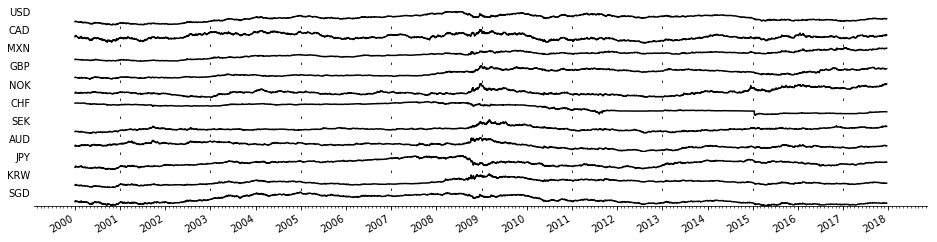

In [2]:
currency = pd.read_csv(os.path.join(data_dir, 'currency.csv'), index_col=0)
x = currency.values.T

fig, ax = plt.subplots(x.shape[0], 1, figsize=(16,4))
date2num = mdates.strpdate2num(fmt='%Y-%m-%d')
dates = [date2num(date) for date in currency.index]
for i, xi in enumerate(x):
    ax[i].plot_date(dates, xi, 'k-')
    ax[i].set_ylabel(currency.columns[i], rotation=0, ha='right')
    ax[i].set_yticks([])
    
for i in range(x.shape[0]-1):
    for spine in ['left', 'right', 'top', 'bottom']:
        ax[i].spines[spine].set_visible(False)
for spine in ['left', 'right', 'top']:
    ax[-1].spines[spine].set_visible(False)
ax[-1].xaxis.set_major_locator(mdates.YearLocator())
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[-1].xaxis.set_minor_locator(mdates.MonthLocator())
fig.autofmt_xdate()
plt.show()

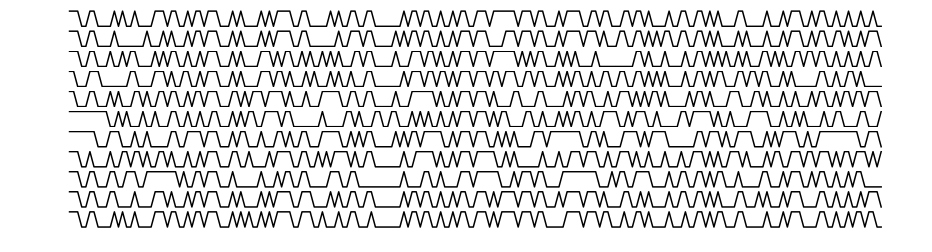

In [3]:
dx = np.diff(x, axis=1)
sx = np.sign(dx).astype(int)
for i, sxi in enumerate(sx):
    sx[i][sxi==0] = np.sign(sxi.mean())
fig, ax = plt.subplots(sx.shape[0], 1, figsize=(16,4))
for i, sxi in enumerate(sx):
    ax[i].plot(sxi[:200], 'k-')
    ax[i].axis('off')

model 1 fit time: 0.13 seconds
model 2 fit time: 0.63 seconds


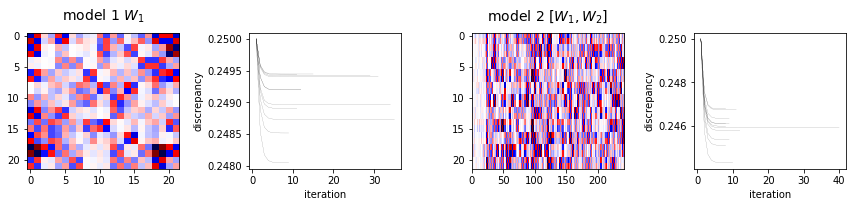

In [ ]:
models = [fem.discrete.fit.model(degs=[1]), fem.discrete.fit.model(degs=[1, 2])]

fig, ax = plt.subplots(1, 4, figsize=(12, 3))

for i, model in enumerate(models):

    start = time.time()
    model.fit(sx[:,:-1], sx[:, 1:], overfit=False)
    end = time.time()
    print 'model %i fit time: %.02f seconds' % (i+1, end-start)
    
    w = np.hstack(model.w.itervalues())
    scale = np.abs(w).max()
    ax[2*i].matshow(w, cmap='seismic', vmin=-scale, vmax=scale, aspect='auto')
    ax[2*i].xaxis.set_ticks_position('bottom')
    
    for d in model.d:
        ax[2*i+1].plot(1 + np.arange(len(d)), d, 'k-', lw=0.1)

    ax[2*i+1].set_xlabel('iteration')
    ax[2*i+1].set_ylabel('discrepancy')

ax[0].set_title('model 1 $W_1$', fontsize=14)
ax[2].set_title('model 2 $[W_1, W_2]$', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
t0, tn, tw, dt = 0, sx.shape[1], 200, 1
t1, t2 = t0, t0+tw
account = np.ones((2, tn))
accuracy = np.zeros((2, tn))

max_weight = 1.0 / 3.0
thresh = 0.75
leverage = 1.0

start = time.time()
while t2 < tn:
    
    price = x[:, t2]
    realized_sx = sx[:, t2]
    realized_dx = dx[:, t2]
    percent_change = realized_dx / price
    
    for i, model in enumerate(models):

        # todays opening balance is yesterdays closing balance
        account[i, t2] = account[i, t2-1]

        # retrain the model
        if not (t1-t0) % dt:
            sx_train = sx[:,t1:t2]
            model.fit(sx_train[:,:-1], sx_train[:, 1:], overfit=False)
        
        # predict tomorrow
        pred, prob = model.predict(sx_train[:, -1])

        # trade if probability above threshold
        trade = prob > thresh

        # if no trades, continue
        if not trade.any():
            continue

        weights = (prob * pred)[trade]
        weights /= np.abs(weights).sum()
        weights[weights > max_weight] = max_weight
        
        position = account[i,t2] * weights

        account[i, t2] += leverage * (position * percent_change[trade]).sum()
        accuracy[i, t2] = (pred == realized_sx)[trade].mean()

    t1 += 1
    t2 += 1
    
end = time.time()
print 'backtest time: %.02f minutes' % ((end-start)/60.,)

In [ ]:
print accuracy.mean(1)

accuracy_rolling_mean = pd.DataFrame(accuracy.T).rolling(100).mean().values.T

fig, ax = plt.subplots(2, 1, figsize=(14, 5))
ax[0].plot(account[0], 'k-')
ax[0].plot(account[1], 'r-')
ax[1].plot(accuracy_rolling_mean[0], 'k-')
ax[1].plot(accuracy_rolling_mean[1], 'r-')
plt.show()